In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The Second Order Runge-Kutta Method is defined by
$$ F_{1,n}=f(t_n,x_n)$$
$$ F_{2,n}=f(t_n+\alpha h,x_n+\alpha h F_{1,n})$$
$$ x_{n+1}=x_n+\beta hF_{1,n}+\gamma hF_{2,n}$$
where $\beta+\gamma=1$ and $\alpha \gamma=\frac{1}{2}$. In this case I have chosen $\beta=\gamma=\frac{1}{2}$ and $\alpha=1$.

In [2]:
def rk2(t,x,x_f,f,h,*args): # I have chosen alpha=1 and beta=gamma=0.5
    F1 = f(t,x_f,*args)
    F2 = f(t+h,x_f+h*F1,*args)
    return x + 0.5*h*F1+0.5*h*F2

The Quasi-Second Order Adams-Bashforth II method we use is defined as:
$$ u^{n+1}=u^n+\Delta t G^{(n+\frac{1}{2})}_{u}$$
$$ G^{(n+\frac{1}{2})}_{u}=(\frac{3}{2}+\epsilon_{AB})G^{(n)}_{u}-(\frac{1}{2}+\epsilon_{AB})G^{(n-1)}_{u}$$
Note that we use RK2 for the first two steps to initialize the method.

In [3]:
def QSAB(t,x,f,h,Gn,Gn1,dudz_Gn,dudz_Gn1,v,w,*args):
    eps = 0
    Gn12 = (1.5+eps)*f(t,Gn,v,w,dudz_Gn,*args)-(0.5+eps)*f(t,Gn1,v,w,dudz_Gn1,*args)
    xn1 = x + h*Gn12
    return xn1

Below we define the system of equations the solver is resolving, they are
$$ \dfrac{\partial u}{\partial t}=fv+\nu_E\dfrac{\partial^2 u}{\partial z^2}$$
$$ \dfrac{\partial v}{\partial t}=f(\bar{u}-u)+\nu_E\dfrac{\partial^2 v}{\partial z^2}$$
where 
$$ \dfrac{\partial^2 u}{\partial z^2}\approx \dfrac{u(z+\Delta z)-2u(z)+u(z-\Delta z)}{\Delta z^2}$$
$$ \dfrac{\partial^2 v}{\partial z^2}\approx \dfrac{v(z+\Delta z)-2v(z)+v(z-\Delta z)}{\Delta z^2}.$$
Note that we assume at the bottom $u=v=0$ for all times and that $\dfrac{\partial u}{\partial z}=\dfrac{\partial u}{\partial z}=0$ at the top so that the second partial derivative term is 0 at the top.

In [4]:
def dudt(t,v,f,vE,dudz):
    out = f*v+vE*dudz # full equation for the derivative of u wrt t
    return out

In [5]:
def dvdt(t,u,f,vE,dvdz,u_bar):
    out = f*(u_bar-u)+vE*dvdz # full equation for the derivative of v wrt t
    return out

In [6]:
dz = 32 # vertical resolution
z = np.arange(0,800.001,dz) # calculate vertical points
u_bar = 0.25 # mean flow away from Ekman Layer
u_prev = np.append(0,u_bar*np.ones(z.shape[0]-1)) # define initial conditions
v_prev = 0*np.ones(z.shape[0])
data_u = np.array([u_prev]).T # store initial conditions in a numpy array
data_v = np.array([v_prev]).T
h = 32 # steps size
total = 16000000 # total amount of time the model is run
T = np.arange(0,total,h) # time domain
omega = ((2*np.pi)/(24*60*60)) # rotation frequenct
phi = 0.5 #latitude
f = 2*omega*np.sin(np.radians(phi)) # coriolis parameter
vE = 1*10**(-2) # eddy viscosity
uGn = u_prev
vGn = v_prev
for i in T[:2]: # iterate over time domain
    dudz = (u_prev[2:]-2*u_prev[1:-1]+u_prev[0:-2])/dz**2
    dvdz = (v_prev[2:]-2*v_prev[1:-1]+v_prev[0:-2])/dz**2
    u = np.array([0]) # bottom conditions
    u = np.append(u,rk2(i,u_prev[1:-1],v_prev[1:-1],dudt,h,f,vE,dudz))
    u = np.append(u,u_bar) # top conditions
    v = np.array([0]) # bottom conditions
    v  = np.append(v,rk2(i,v_prev[1:-1],u_prev[1:-1],dvdt,h,f,vE,dvdz,u_bar))
    v = np.append(v,0) # top conditions
    if i%16000==0: #Note: For the sake of timeliness, please do not save at every time step
        data_u = np.append(data_u,np.array([u]).T,axis=1) # data u and data v have the data from each time step stored,
        data_v = np.append(data_v,np.array([v]).T,axis=1) # with the first dimension serving as time and second as point in z
    u_prev = u
    v_prev = v
    uGn1 = uGn
    vGn1 = vGn
    uGn = u_prev
    vGn = v_prev
for i in T[2:]: # iterate over time domain
    dudz_Gn = (uGn[2:]-2*uGn[1:-1]+uGn[0:-2])/dz**2
    dudz_Gn1 = (uGn1[2:]-2*uGn1[1:-1]+uGn1[0:-2])/dz**2
    dvdz_Gn = (vGn[2:]-2*vGn[1:-1]+vGn[0:-2])/dz**2
    dvdz_Gn1 = (vGn1[2:]-2*vGn1[1:-1]+vGn1[0:-2])/dz**2
    u = np.array([0]) # bottom conditions
    u = np.append(u,QSAB(i,u_prev[1:-1],dudt,h,vGn[1:-1],vGn1[1:-1],dudz_Gn,dudz_Gn1,f,vE))
    u = np.append(u,u_bar) # top conditions
    v = np.array([0])
    v = np.append(v,QSAB(i,v_prev[1:-1],dvdt,h,uGn[1:-1],uGn1[1:-1],dvdz_Gn,dvdz_Gn1,f,vE,u_bar))
    v = np.append(v,0) # top conditions
    if i%16000==0: #Note: For the sake of timeliness, please do not save at every time step
        data_u = np.append(data_u,np.array([u]).T,axis=1) # data u and data v have the data from each time step stored,
        data_v = np.append(data_v,np.array([v]).T,axis=1) # with the first dimension serving as time and second as point in z
    u_prev = u
    v_prev = v
    uGn1 = uGn
    vGn1 = vGn
    uGn = u_prev
    vGn = v_prev

Below calculates the Ekman depth:

In [7]:
d = np.sqrt((2*vE)/f)
print(f"The Ekman Depth is {d}")

The Ekman Depth is 125.52956019134824


Below are contour plots for the components of velocity.

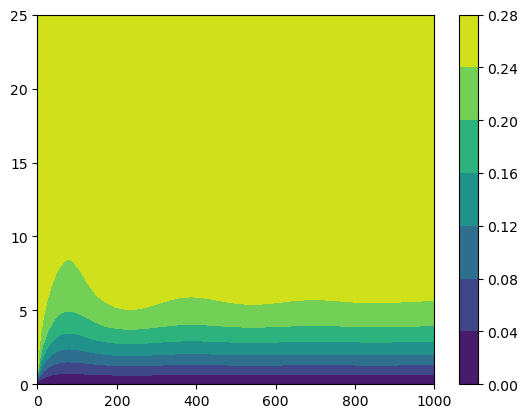

In [8]:
cs = plt.contourf(data_u)
plt.colorbar(cs)

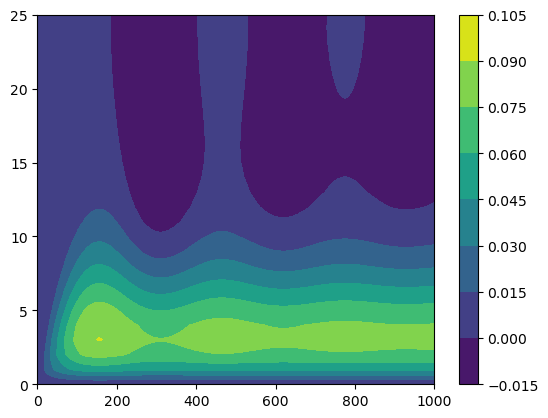

In [9]:
cs = plt.contourf(data_v)
plt.colorbar(cs)

Below are the plots of the u and v components of velocity in the water column at a specific time.

Text(0, 0.5, 'depth')

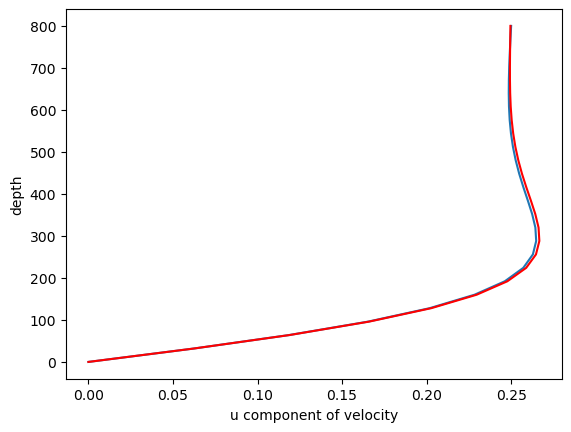

In [10]:
# zn = np.arange(0,101.1,2)
plt.plot(data_u[:,-1],z)
plt.plot(u_bar*(1-np.exp(-z/d)*np.cos(z/d)),z,c="r")
plt.xlabel("u component of velocity")
plt.ylabel("depth")

Text(0, 0.5, 'depth')

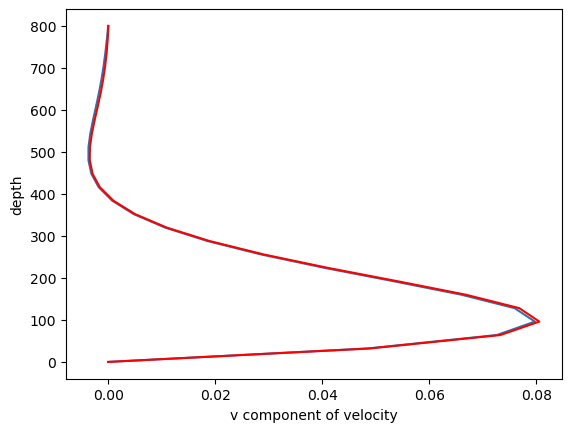

In [11]:
# plt.plot(data_v[-1,0:400],z[0:400])
plt.plot(data_v[:,-1],z)
plt.plot(u_bar*np.exp(-z/d)*np.sin(z/d),z,c="r")
plt.xlabel("v component of velocity")
plt.ylabel("depth")

In [13]:
V = np.sum(dz*data_v[:,-1])
print(f"The net transport of fluid is {V}")

The net transport of fluid is 15.176173788343068
